In [1]:
from scipy import stats
import numpy as np
import CombinedFCToolBox as cfc  #import the combinedFC toolbox
import matplotlib.pyplot as plt

# Demo for CombinedFC Toolbox functions

### For more information and details about the functions and methods implemented here refer to: Sanchez-Romero, R., Cole, M.W. (Preprint) "Combining multiple functional connectivity methods to improve causal inferences" bioRxiv. https://doi.org/10.1101/841890

## Content
1. Apply combinedFC to a single empirical dataset
2. Apply combinedFC to group data
3. Simulate networks and data
4. Alternative implementations of combinedFC
5. Simulate and apply combinedFC to a high-dimensional dataset (nodes >> datapoints)
***

## 1. Apply combinedFC to a single empirical dataset

### Load data from the hcp_data directory

In [2]:
#Load data for a single subject

#NOTE: Here we are using the "hcp_data" directory included in the repository
#which includes 100 subjects resting-state fMRI from the HCP, parcellated into 360 regions

#IMPORTANT: The user need to format her own datasets as:
#matrix with dimensions [datapoints x nodes] and no headers.

#NOTE: The following are steps to read and load data in h5 format
#(http://docs.h5py.org/en/stable/)

#The user should adjust the script according to her own datasets
#For example, to load a txt file the user can use the numpy loadtxt function
#(https://docs.scipy.org/doc/numpy/reference/generated/numpy.loadtxt.html)
#eg., for a comma separated file with headers in the first row use:
#data = np.loadtxt('datafile.txt',comments='None', delimiter=',',skiprows=1)


import h5py
datadir = 'hcp_data'  #directory path for the datasets
subject_id = '100206'  #just select one of the subjects. The directory has 100.
#HCP data includes 4 resting state fMRI datasets per subjects,
#select how many of these you want to concatenate
#In this example, we just use 2 of the datasets            
restRuns = ['rfMRI_REST1_RL','rfMRI_REST1_LR'] #,'rfMRI_REST2_RL', 'rfMRI_REST2_LR']
#Read the h5 file
h5file = h5py.File(f'{datadir}/{subject_id}_data.h5','r')
#initialize the variable where the data will be concatenated
rest_data = []
#loop through the resting state fMRI datasets that were selected in restRuns
for run in restRuns:
    #extract the resting-state data from the h5 file, [:] loads it as an array
    tmp = h5file[f'{run}/nuisanceReg_resid_24pXaCompCorXVolterra'][:]
    #concatenate the resting state datasets (transpose to get [nDatapoints x nNodes])
    rest_data.extend(tmp.T)
    
#save the nDatapoints x 360 nodes dataset (1195 datapoints per run)
rest_data = np.asarray(rest_data)
#IMPORTANT: close the h5 file
h5file.close()

print(f'Subject {subject_id} dataset with {rest_data.shape[0]} datapoints and {rest_data.shape[1]} nodes')

Subject 100206 dataset with 2390 datapoints and 360 nodes


### Apply combinedFC

In [3]:
#Important: the dataset input has to be a matrix [datapoints x nodes], and without header.
#see the function code for more details.

#Returns the symmetric combinedFC connectivity matrix [nodes x nodes]
Mcfc_subj = cfc.combinedFC(dataset = rest_data,  
            methodCondAsso = 'partialCorrelation', #method used to compute conditional associations
            methodParcorr='inverseCovariance',     #if Partial Correlation, choose "inversecovariance" or "regression"
            alphaCondAsso = 0.01,                  #alpha cutoff for conditional association
            methodAsso = 'correlation',            #method used to compute bivariate associations
            alphaAsso = 0.01,                      #alpha curtoff for bivariate association
            equivalenceTestAsso = False,           #True for equivalence test, False for non-significance criterion
            lower_bound = -0.2,                    #lower bound for equivalence test
            upper_bound = +0.2                     #upper bound for equivalence test
            )

### Plot the combinedFC weighted connectivity matrix

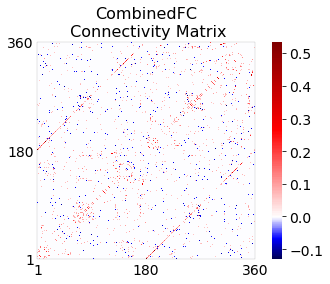

In [4]:
#Plot the combinedFC symmetric weighted connectivity matrix
#with a colorbar with red for positive and blue for negative values
fig, ax = cfc.plotConnectivityMatrix(ConnMat = Mcfc_subj,         #input weighted connectivity matrix
                           methodTitle='CombinedFC\n Connectivity Matrix',    #title for the plot
                           )  
fig.show()

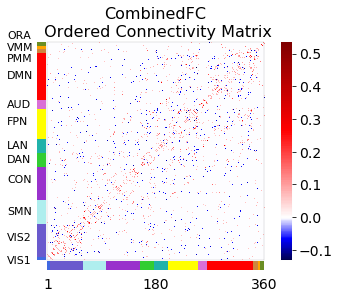

In [5]:
#This function will also plot the HCP data connectivity matrix ordering 
#the 360 Glasser parcellation nodes (https://www.nature.com/articles/nature18933)
#using the functional networks defined in Ji et al., (2019)
#https://www.sciencedirect.com/science/article/pii/S1053811918319657

fig, ax = cfc.plotConnectivityMatrix(ConnMat = Mcfc_subj,                   #input matrix
                                methodTitle='CombinedFC\n Ordered Connectivity Matrix',    #title for the plot
                                functionalNetworks = True,   #True, if using Ji et al., (2019) functional networks order
                                networkColorBar_x = True,   #include color marks in x axis for the functional networks
                                networkColorBar_y = True,    #do not include color marks in y axis
                                networkLabels = True)        #include labels for the Ji et al., networks
fig.show()

## 2. Apply combinedFC to group data

### Load data for all the subjects in the group, from the hcp_data directory

In [26]:
#IMPORTANT: The individual subjects data has to be saved as a list to input to combinedFC
#recall that each individual dataset has to be in a matrix with dimentions [datapoints x nodes]
#Here we show how we did it for the hcp_data directory datasets saved in h5 format.

#If the user has her datasets in txt files in a directory the following pseudocode using numpy
#loadtxt could be used:
# group_data = []   #initialize a list
# for each subject.txt file in your directory do:
#   data = np.loadtxt('subject.txt')
#   group_data.append(data)   #to save the individual data as a list


import h5py
#directory of the hcp data in h5 format
datadir = 'hcp_data'
#labels for the pool of 100 hcp subjects
subjects = ['100206','108020','117930','126325','133928','143224','153934','164636','174437',
            '183034','194443','204521','212823','268749','322224','385450','463040','529953',
            '587664','656253','731140','814548','877269','978578','100408','108222','118124',
            '126426','134021','144832','154229','164939','175338','185139','194645','204622',
            '213017','268850','329844','389357','467351','530635','588565','657659','737960',
            '816653','878877','987074','101006','110007','118225','127933','134324','146331',
            '154532','165638','175742','185341','195445','205119','213421','274542','341834',
            '393247','479762','545345','597869','664757','742549','820745','887373','989987',
            '102311','111009','118831','128632','135528','146432','154936','167036','176441',
            '186141','196144','205725','213522','285345','342129','394956','480141','552241',
            '598568','671855','744553','826454','896879','990366','102513','112516','118932',
            '129028']

#just use one resting state run per subjects             
restRuns = ['rfMRI_REST1_RL'] #'rfMRI_REST1_LR','rfMRI_REST2_RL', 'rfMRI_REST2_LR']

#initialize the list that will contain the nSubjects datasets
group_restData = []

#extract individual datasets and populate the list
#loop through all the subjects
for subject in subjects:
    h5file = h5py.File(f'{datadir}/{subject}_data.h5','r')
    rest_data = []
    for run in restRuns:
        #extract the resting-state data, [:] loads it as an array
        tmp = h5file[f'{run}/nuisanceReg_resid_24pXaCompCorXVolterra'][:]
        #concatenate the resting state datasets from restRuns
        rest_data.extend(tmp.T)
    #save the nDatapoints x 360 nodes dataset as an array (1195 datapoints per run)
    rest_data = np.asarray(rest_data)
    #important, save the h5 file
    h5file.close()
    #append to the group data list
    group_restData.append(rest_data)
    
print(f'group_restData contains a list of {len(group_restData)} subjects')
print(f'Each subject dataset contains {group_restData[0].shape[0]} datapoints and {group_restData[0].shape[1]} nodes')

group_restData contains a list of 100 subjects
Each subject dataset contains 1195 datapoints and 360 nodes


### Apply combinedFC at the group level and use an equivalence test for the zero correlations

In [7]:
#IMPORTANT: The input is a list containing the subjects individual datasets with dimensions [datapoints x nodes]
#The output is a group combinedFC connectivity matrix with dimensions [nodes x nodes]

#See the manuscript for information about computation and interpretation of the group matrix
#In sum, each entry in the matrix represents the group average significant connectivity weight

#See the manuscript for meaning and use of the equivalence test in group analysis

Mcfc_group = cfc.groupCombinedFC(groupData = group_restData,   #list containing the subjects individual datasets 
                    alpha = 0.01,                          #alpha level for partial correlation
                    methodParcorr ='inverseCovariance',    #method to compute the partial correlation
                    equivalenceTest = True,                #If True, compute an equivalence test for zero correlations
                    lower_bound = -0.2,                    #lower and upper bound representing the minimum correlation of
                    upper_bound = +0.2,                    #interest for the equivalence test
                    alphaEqTest = 0.01                      #alpha level for the equivalence test
                    )                   

### Plot the group combinedFC weighted connectivity matrix

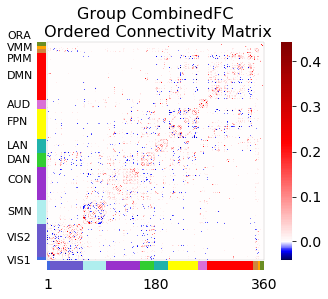

In [8]:
fig, ax = cfc.plotConnectivityMatrix(ConnMat = Mcfc_group,   #input group weighted matrix       
                                methodTitle='Group CombinedFC\n Ordered Connectivity Matrix',   
                                functionalNetworks = True,   #order in functional networks from Ji et al.,(2019)
                                networkColorBar_x = True,    #include color marks in x axis for the functional networks
                                networkColorBar_y = True,    #do not include color marks in y axis
                                networkLabels = True)        #include labels for the Ji et al., networks
fig.show()

## 3. Simulate networks and data

### Simulate a directed network model: adjusted Erdos-Renyi or adjusted Static Power Law

directed network with 200 nodes and 920 edges


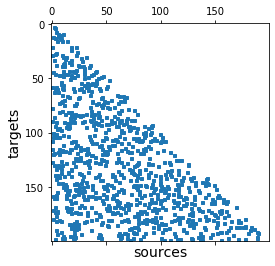

In [9]:
#the graphModel function requires installation: "conda install -c conda-forge python-igraph"
#or "pip install python-igraph"
#https://igraph.org/python/

model = 'ErdosRenyi'  #or StaticPowerLaw
edgedensity = 900 #aprox. number of edges
nNodes = 200 #number of nodes

#returns a binary directed network encoded as column(source) -> row(target)
#for example, the entry Cij, implies that j -> i (j is a directed cause of i)
C = cfc.graphModel(model,edgedensity*2,nNodes)

#Note: the user can define her own model as long as it is a binary
#directed matrix encoded as column(source) -> row(target).

#plot the network model
real_nEdges = np.sum(C==1) #get the real number of edges
print(f'directed network with {nNodes} nodes and {real_nEdges} edges')
plt.spy(C,markersize=3)
plt.xlabel('sources',fontsize=14)
plt.ylabel('targets',fontsize=14)
plt.show()

### Simulate data for the network, using the linear model X = WX + E, and pseudoempirical noise terms E

In [10]:
#use the network model defined above
network = C 
#Connectivity coefficients are sampled from a Uniform(min,max) distribution
min_coefficient = -1
max_coefficient = 1
number_datapoints = 1200

#returns a dataset X [datapoints x nodes] and a coefficient matrix W [nodes x nodes]
X, W = cfc.simulateData.pseudoEmpiricalData(network, 
                                            min_coeff = min_coefficient, 
                                            max_coeff = max_coefficient, 
                                            nDatapoints=number_datapoints
                                            )

### An alternative to the pseudoEmpirical noise terms is to sample E from a Standard Gaussian (or Beta)

In [11]:
#network model defined above
network = C 
#Connectivity coefficients are sampled from a Uniform(min,max) distribution
min_coefficient = -1
max_coefficient = 1
number_datapoints = 1200
type_distribution = 'Gaussian' #standard Gaussian(mean=0,std=1) or "nonGaussian" a Beta(1,5)

X, W = cfc.simulateData.syntheticData(network, 
                                      min_coeff = min_coefficient, 
                                      max_coeff = max_coefficient, 
                                      nDatapoints = number_datapoints,
                                      distribution = type_distribution
                                      )

### Apply combinedFC to the simulated data

In [12]:
#Important: the dataset input has to be a matrix [datapoints x nodes], and without header.
#see the function code for more details.

#Returns the symmetric combinedFC connectivity matrix [nodes x nodes]
Mcfc = cfc.combinedFC(dataset = X,  
            methodCondAsso = 'partialCorrelation', #method used to compute conditional associations
            methodParcorr='inverseCovariance',     #if Partial Correlation, choose "inversecovariance" or "regression"
            alphaCondAsso = 0.01,                  #alpha cutoff for conditional association
            methodAsso = 'correlation',            #method used to compute bivariate associations
            alphaAsso = 0.01,                      #alpha curtoff for bivariate association
            equivalenceTestAsso = False,           #True for equivalence test, False for non-significance criterion
            lower_bound = -0.2,                    #lower bound for equivalence test
            upper_bound = +0.2                     #upper bound for equivalence test
            )

### Apply partial correlation to the simulated data

In [13]:
#returns the symmetric partial correlation connectivity matrix [nodes x nodes]
M_parcorr = cfc.partialCorrelationSig(dataset =X, 
                                      alpha = 0.01, 
                                      method = 'inverseCovariance'   #"inverseCovariance" or "regression"
                                      )

### Apply bivariate correlation to the simulated data

In [14]:
#returns the symmetric bivariate correlation connectivity matrix [nodes x nodes]
M_corr = cfc.correlationSig(dataset = X,
                            alpha=0.01  #alpha cutoff for the significance test: two-sided z-test
                            )   

### Accuracy of the methods in the simulation, using precision and recall
We want to quantify the accuracy of a method to recover the adjacencies of the true model.
<br>
precision = true positives / (true positives + false positives)
<br>
recall = true positives / (true positives + false negatives)

In [15]:
# the true model is the simulated network C
trueModel = C

#estimated models
estimatedModel = Mcfc
precision = cfc.precision(estimatedModel,trueModel)
recall = cfc.recall(estimatedModel,trueModel)
#print results
print(f'combinedFC accuracy:')
print(f'precision: {round(precision,3)}')  #round up result to 3 decimals
print(f'recall: {round(recall,3)}')
print(' ')


estimatedModel = M_parcorr
precision = cfc.precision(estimatedModel,trueModel)
recall = cfc.recall(estimatedModel,trueModel)
print(f'partial correlation accuracy:')
print(f'precision: {round(precision,3)}')
print(f'recall: {round(recall,3)}')
print(' ')

estimatedModel = M_corr
precision = cfc.precision(estimatedModel,trueModel)
recall = cfc.recall(estimatedModel,trueModel)
print(f'bivariate correlation accuracy:')
print(f'precision: {round(precision,3)}')
print(f'recall: {round(recall,3)}')

combinedFC accuracy:
precision: 0.612
recall: 0.733
 
partial correlation accuracy:
precision: 0.377
recall: 0.82
 
bivariate correlation accuracy:
precision: 0.092
recall: 0.859


## 4. Alternative implementations of combinedFC

### Implement combinedFC with the regression approach for partial correlation and an equivalence test for zero correlations

In [16]:
Mcfc_eq = cfc.combinedFC(dataset = X,  
                methodCondAsso = 'partialCorrelation', #method used to compute conditional associations
                methodParcorr='regression',            #for Partial Correlation, "inversecovariance" or "regression"
                alphaCondAsso = 0.01,                  #alpha cutoff for conditional association
                methodAsso = 'correlation',            #method used to compute bivariate associations
                alphaAsso = 0.01,                      #alpha curtoff for bivariate association
                equivalenceTestAsso = True,            #True for equivalence test, False for non-significance criterion
                lower_bound = -0.2,                    #lower bound for equivalence test
                upper_bound = +0.2                     #upper bound for equivalence test
                )

### Accuracy of combinedFC with the regression approach for partial correlation and an equivalence test for zero correlations

In [17]:
trueModel = C
estimatedModel = Mcfc_eq
precision = cfc.precision(estimatedModel,trueModel)
recall = cfc.recall(estimatedModel,trueModel)
print(f'combinedFC with regression approach for partial correlation and an Equivalence test, accuracy:')
print(f'precision: {round(precision,3)}')
print(f'recall: {round(recall,3)}')

combinedFC with regression approach for partial correlation and an Equivalence test, accuracy:
precision: 0.719
recall: 0.656


### Implement combinedFC with simple regression and multiple regression

In [18]:
#returns the symmetric combinedFC connectivity matrix [nodes x nodes]
Mcfc_reg = cfc.combinedFC(dataset = X,  
                   methodCondAsso = 'multipleRegression', #use multiple regression for conditional associations  
                   alphaCondAsso = 0.01,                  #alpha cutoff for the multiple regression coefficients
                   methodAsso = 'simpleRegression',       #use simple regression for the bivariate associations        
                   alphaAsso = 0.01,                      #alpha cutoff for the simple regression coefficients 
                    )

### Accuracy of combinedFC with simple regression and multiple regression

In [19]:
trueModel = C
estimatedModel = Mcfc_reg
precision = cfc.precision(estimatedModel,trueModel)
recall = cfc.recall(estimatedModel,trueModel)
print(f'combinedFC with simple and multiple regression, accuracy:')
print(f'precision: {round(precision,3)}')
print(f'recall: {round(recall,3)}')

combinedFC with simple and multiple regression, accuracy:
precision: 0.611
recall: 0.732


## 5. Simulate and apply combinedFC to a high-dimensional dataset (nodes >> datapoints)

In [27]:
#define a directed network
model = 'StaticPowerLaw'  #or ErdosRenyi
edgedensity = 1000 #aprox. number of edges
nNodes = 800 #number of nodes
#call the function to generate the network
C = cfc.graphModel(model,edgedensity*2,nNodes)

real_nEdges = np.sum(C==1)
print(f'directed network with {nNodes} nodes and {real_nEdges} edges')

directed network with 800 nodes and 1685 edges


In [28]:
#generate the high-dimensional dataset using the above directed network
network = C #network model defined above
#Connectivity coefficients are sampled from a Uniform(min,max) distribution
min_coefficient = -1
max_coefficient = 1
#number of nodes of the network
nNodes = network.shape[1]
#define number of datapoints to be half of the number of nodes (nodes >> datapoints)
number_datapoints = np.round(nNodes/2).astype(int) #round and define as integer

#generate data using Gaussian noise terms E
type_distribution = 'Gaussian'  #standard Gaussian(mean = 0,std =1)
X_hd, W_hd = cfc.simulateData.syntheticData(network, 
                                            min_coeff = min_coefficient, 
                                            max_coeff = max_coefficient, 
                                            nDatapoints = number_datapoints,
                                            distribution = type_distribution
                                            )
print(f'X_hd dataset has {X_hd.shape[1]} nodes and {X_hd.shape[0]} datapoints')

X_hd dataset has 800 nodes and 400 datapoints


### Implement combinedFC with a high-dimensional method to compute partial correlations
The method used is glasso, a regularized solution to the inverse covariance approach for high-dimensional datasets.

In [ ]:
#the glasso implementation uses as default a cross-validation with 10 kfolds to choose the regularization parameter
Mcfc_hd = cfc.combinedFC(dataset = X_hd,  
                    methodCondAsso = 'partialCorrelation', #method for conditional associations
                    methodParcorr = 'glasso',              #use glasso as method for partial correlations
                    alphaCondAsso = 0.01,                  #alpha cutoff for the multiple regression coefficients
                    methodAsso = 'correlation',            #use simple regression for the bivariate associations        
                    alphaAsso = 0.01,                      #alpha cutoff for the simple regression coefficients
                    )

### Apply partial correlation using glasso to the high-dimensional dataset

In [30]:
#the glasso implementation uses as default a cross-validation with 10 kfolds to choose the regularization parameter
Mparcorr_hd = cfc.partialCorrelationSig(dataset =X_hd, 
                                      alpha = 0.01, 
                                      method = 'glasso'   #use glasso for high-dimensional datasets
                                      )

### Apply correlation to the high-dimensional dataset

In [31]:
Mcorr_hd = cfc.correlationSig(dataset = X_hd,
                            alpha=0.01  #alpha cutoff for the significance test: two-sided z-test
                            )   

### Precision and recall of the methods for the high-dimensional problem

In [32]:
# the true model is the simulated network C
trueModel = C

estimatedModel = Mcfc_hd
precision = cfc.precision(estimatedModel,trueModel)
recall = cfc.recall(estimatedModel,trueModel)
print(f'combinedFC using glasso to compute partial correlations, accuracy:')
print(f'precision: {round(precision,3)}')
print(f'recall: {round(recall,3)}')
print(' ')

estimatedModel = Mparcorr_hd
precision = cfc.precision(estimatedModel,trueModel)
recall = cfc.recall(estimatedModel,trueModel)
print(f'partial correlation using glasso, accuracy:')
print(f'precision: {round(precision,3)}')
print(f'recall: {round(recall,3)}')
print(' ')

estimatedModel = Mcorr_hd
precision = cfc.precision(estimatedModel,trueModel)
recall = cfc.recall(estimatedModel,trueModel)
print(f'bivariate correlation accuracy:')
print(f'precision: {round(precision,3)}')
print(f'recall: {round(recall,3)}')

combinedFC using glasso to compute partial correlations, accuracy:
precision: 0.641
recall: 0.513
 
partial correlation using glasso, accuracy:
precision: 0.485
recall: 0.538
 
bivariate correlation accuracy:
precision: 0.202
recall: 0.577
